## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import yfinance
import cpi


C:\Users\41763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:8: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  


## Data Preparation Parameters

In [2]:
# Parameters to choose:

# Minimum number of movies to consider a country,language or genre
Min_count_count = 20
Min_lang_count = 20
Min_genre_count = 20

# Sucess threshold for a movie to be considered sucessful on the normalized revenue
Sucess_revenue_threshold = 1.5


### Movie Data Processing Functions

In [3]:
def movie_data_processing():
    """
    This function loads the data from the MovieSummaries dataset and processes it to be used in the analysis
    Returns
    -------
    movies: pandas dataframe
        A dataframe containing the processed data
    """
    # Loading data from MovieSummaries dataset
    movies = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
    
    # Renaming columns for clarity
    movies.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
    
    # Dropping unnecessary columns
    movies.drop('Freebase movie ID', axis=1, inplace=True)
    
    # Processing columns with dictionaries
    movies["Movie languages"]=movies["Movie languages"].map(lambda x: set(ast.literal_eval(x).values()))
    movies["Movie countries"]=movies["Movie countries"].map(lambda x: set(ast.literal_eval(x).values()))
    movies['Movie genres']=movies['Movie genres'].map(lambda x: set(ast.literal_eval(x).values()))
    
    # Dropping duplicate entries based on Wikipedia movie ID
    movies.drop_duplicates(subset=['Wikipedia movie ID'],inplace=True)
    
    return movies
movies = movie_data_processing()

In [4]:
def process_dict_columns(movies):
    """
    This function processes the columns containing dictionaries in the movies dataframe
    It deletes some categories with less than Min_..._count movies and deletes movies with no categories left
    Parameters
    ----------
    movies: pandas dataframe
        The dataframe containing the movies data
    Returns
    -------
    movies: pandas dataframe
        The dataframe containing the processed data
    """
    
    # Extracting unique elements from columns with dictionaries
    union_lang = set().union(*movies["Movie languages"])
    union_count = set().union(*movies['Movie countries'])
    union_genres = set().union(*movies['Movie genres'])
    
    # Printing the number of unique elements for each category
    print("Number of languages: ", len(union_lang))
    print("Number of countries: ", len(union_count))
    print("Number of genres: ", len(union_genres))

    # Counting occurrences of each language, genre, and country
    # Creating dataframes for counts and filtering based on minimum count threshold
    lang_count = {}
    for lang in union_lang:
        lang_count[lang] = 0
    for lang in movies["Movie languages"]:
        for l in lang:
            lang_count[l] += 1
    lang_count = pd.DataFrame.from_dict(lang_count, orient='index', columns=['Count'])
    lang_count.sort_values(by=['Count'], ascending=False, inplace=True)
    lang_count = lang_count[lang_count['Count'] > Min_lang_count]
    print(f"Number of languages with more than {Min_lang_count} movies: ", len(lang_count))

    genre_count = {}
    for genre in union_genres:
        genre_count[genre] = 0
    for genre in movies['Movie genres']:
        for g in genre:
            genre_count[g] += 1
    genre_count = pd.DataFrame.from_dict(genre_count, orient='index', columns=['Count'])
    genre_count.sort_values(by=['Count'], ascending=False, inplace=True)
    genre_count = genre_count[genre_count['Count'] > Min_genre_count]
    print(f"Number of genres with more than {Min_genre_count} movies: ", len(genre_count))

    count_count = {}
    for count in union_count:
        count_count[count] = 0
    for count in movies['Movie countries']:
        for c in count:
            count_count[c] += 1
    count_count = pd.DataFrame.from_dict(count_count, orient='index', columns=['Count'])
    count_count.sort_values(by=['Count'], ascending=False, inplace=True)
    count_count = count_count[count_count['Count'] > Min_count_count]
    print(f"Number of countries with more than {Min_count_count} movies: ", len(count_count))
    
    # Filtering movies based on the remaining categories
    movies["Movie languages"] = movies["Movie languages"].map(lambda x: set([l for l in x if l in lang_count.index]))
    movies["Movie countries"] = movies["Movie countries"].map(lambda x: set([c for c in x if c in count_count.index]))
    movies["Movie genres"] = movies["Movie genres"].map(lambda x: set([g for g in x if g in genre_count.index]))
    
    # Removing movies with no categories left
    movies.drop(movies[movies["Movie languages"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie countries"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie genres"].map(lambda x: len(x)) == 0].index, inplace=True)
    return movies

movies = process_dict_columns(movies)

Number of languages:  207
Number of countries:  147
Number of genres:  363
Number of languages with more than 20 movies:  81
Number of genres with more than 20 movies:  245
Number of countries with more than 20 movies:  88


In [5]:
## CAREFUL This will make that many films will be published the 1st of January
def modify_movie_release_date(movies):
    """
    This function processes the movie release date column.
    
    It deletes movies with no release date and modifies the format of the date.
    For the movies with no precise release date, it sets the release date to the 1st of January of the year of the movie
    Parameters
    ----------
    movies: pandas dataframe
        The dataframe containing the movies data
    Returns
    -------
    movies: pandas dataframe
        The dataframe containing the processed data
    """
    
    # Drop movies with non-string release dates
    movies.drop(movies[movies['Movie release date'].map(lambda x: type(x)!=str)].index, inplace=True)
    
    # Fixing a date error for a specific movie
    movies.loc[movies['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'

    # Modify release dates to have a uniform format
    movies["Movie release date"]=movies["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    
    # Extracting the release year and adding it as a separate column
    movies['Movie Year Release'] = movies['Movie release date'].map(lambda x: int(x.split('-')[0]))
    
    return movies

movies = modify_movie_release_date(movies)

### Mergin revenue column with TMDB and adding budget

In [6]:
def modif_name(x):
    """
    Helper function to merge the movies dataframes on name and release year.
    
    Parameters
    ----------
    x: tuple
        A tuple containing two movie names.

    Returns
    -------
    str or bool:
        Returns the modified name if found in the 'movies' dataframe; otherwise, returns False.
    """
    if x[0].lower() in movies['modified name'].values:
        return x[0].lower()
    elif x[1].lower() in movies['modified name'].values:
        return x[1].lower()
    else:
        return False

def merge_revenue(x):
    """
    Helper function to merge the revenues from all the dataframes joined.
    
    Parameters
    ----------
    x: pandas Series
        A row from the joined dataframes.

    Returns
    -------
    float or np.nan:
        Returns the movie box office revenue if available; otherwise, returns NaN.
    """
    if x['Movie box office revenue']>0:
        return x['Movie box office revenue']
    elif x['revenue_left']>0:
        return x['revenue_left']
    elif x['revenue_right']>0:
        return x['revenue_right']
    else:
        return np.nan

def merge_budget(x):
    """
    Helper function to merge the budgets from all the dataframes joined.
    
    Parameters
    ----------
    x: pandas Series
        A row from the joined dataframes.

    Returns
    -------
    int or np.nan:
        Returns the movie budget if available; otherwise, returns NaN.
    """
    if type(x['budget_left'])==str and int(x['budget_left'])>0:
        return int(x['budget_left'])
    elif type(x['budget_right'])==str and int(x['budget_right'])>0:
        return int(x['budget_right'])
    else:
        return np.nan

def merging_revenu_budget(movies):

    """
    This function merges the movies dataframe with the data from the other datasets.
    It merges on the name and the release year.
    It also merges the revenue and the budget.
    
    Parameters
    ----------
    movies: pandas dataframe
        The dataframe containing the movies data
    Returns
    -------
    full_joined: pandas dataframe
        The dataframe containing the processed data
    """
    
    # Load additional datasets
    tmdb_scrapped = pd.read_csv('data/tmdb_scrapped_full.csv')
    tmdb_scrapped['release_year']=tmdb_scrapped['release_date'].map(lambda x: int(x.split('-')[0]))
    the_movies = pd.read_csv("data/the-movies-dataset/movies_metadata.csv")
    the_movies.dropna(subset=['title','original_title','release_date'],inplace=True)
    the_movies['release_year']=the_movies['release_date'].map(lambda x: int(x.split('-')[0]))
    
    # Modify the 'movies' dataframe
    movies['modified name']=movies['Movie name'].map(lambda x: x.lower())
    
    # Create modified names for 'the_movies' and 'tmdb_scrapped'
    names = []
    for i in the_movies.index:
        names.append(modif_name(the_movies.loc[i,['title','original_title']]))
    the_movies['modified name']=names

    names = []
    for i in tmdb_scrapped.index:
        names.append(modif_name(tmdb_scrapped.loc[i,['title','original_title']]))
    tmdb_scrapped['modified name']=names
    
    # Join the dataframes
    temporary_joined = movies.join(the_movies.set_index(['modified name',"release_year"]), on=['modified name','Movie Year Release'], how='left', lsuffix='_left', rsuffix='_right')
    full_joined = temporary_joined.join(tmdb_scrapped.set_index(['modified name',"release_year"]), on=['modified name','Movie Year Release'], how='left', lsuffix='_left', rsuffix='_right')
    full_joined.drop_duplicates(subset=['Wikipedia movie ID'],inplace=True)

    # Calculate full revenue and full budget
    L= []
    for i in full_joined.index:
        L.append(merge_revenue(full_joined.loc[i]))
    full_joined['full revenue']=L

    L1= []
    for i in full_joined.index:
        L1.append(merge_budget(full_joined.loc[i]))
    full_joined['full budget']=L1

    # Drop unnecessary columns
    full_joined.drop(['modified name',"adult_left","belongs_to_collection_left",'budget_left', 'genres_left', 'homepage_left', 'id_left','imdb_id_left', 'original_language_left', 'original_title_left',
       'overview_left', 'popularity_left', 'poster_path_left','production_companies_left', 'production_countries_left','release_date_left', 'revenue_left', 'runtime_left',
       'spoken_languages_left', 'status_left', 'tagline_left', 'title_left','video_left', 'vote_average_left', 'vote_count_left', 'Unnamed: 0.1','Unnamed: 0', 'adult_right', 'backdrop_path',
       'belongs_to_collection_right', 'budget_right', 'genres_right','homepage_right', 'id_right','original_language_right', 'original_title_right', 'overview_right',
       'popularity_right', 'poster_path_right', 'production_companies_right','production_countries_right', 'release_date_right', 'revenue_right','runtime_right', 'spoken_languages_right', 'status_right','tagline_right', 'title_right', 'video_right', 'vote_average_right',
       'vote_count_right'],axis=1,inplace=True)
    
    # Drop the original movie box office revenue column
    full_joined.drop(['Movie box office revenue'],axis=1,inplace=True)
    
    # Rename columns
    full_joined.rename(columns={'imdb_id_right':'IMDB id','full revenue':'Movie box office revenue','full budget':'Movie budget'},inplace=True)
    return full_joined

full_joined = merging_revenu_budget(movies)

#or this if you want to gain time:
# full_joined = pd.read_csv('data/movie_with_merged_revenue.csv')
movies=full_joined.copy()

C:\Users\41763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:135: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.


### Characters

In [7]:
def characters_data_process():
    """
    This function loads the characters data from the MovieSummaries dataset and processes it to be used in the analysis
    Returns
    -------
    characters: pandas dataframe
        A dataframe containing the processed data
    """
    
    # Load characters data
    characters = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
    
    # Rename columns for better readability
    characters = characters.rename(columns={0: 'Wikipedia movie ID', 1: 'Freebase movie ID', 2: 'Movie release date', 3: 'Character name', 4: 'Actor date of birth', 5: 'Actor gender', 6: 'Actor height (in meters)', 7: 'Actor ethnicity (Freebase ID)', 8: 'Actor name', 9: 'Actor age at movie release', 10: 'Freebase character/actor map ID', 11: 'Freebase character ID', 12: 'Freebase actor ID'})
    
    # Drop unnecessary columns
    characters.drop('Freebase movie ID', axis=1, inplace=True)
    characters.drop('Freebase character/actor map ID', axis=1, inplace=True)
    characters.drop('Freebase character ID', axis=1, inplace=True)
    characters.drop('Freebase actor ID', axis=1, inplace=True)

    # Drop 'Actor ethnicity (Freebase ID)' as it might not be useful
    characters.drop('Actor ethnicity (Freebase ID)', axis=1, inplace=True)
    
    # Process 'Movie release date'
    characters["Movie release date"] = characters["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    
    # Correct a date error
    characters.loc[characters['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'
    
    # Drop rows with missing values in 'Character name' or 'Actor name'
    characters.dropna(subset=['Character name',"Actor name"], inplace=True)
    
    # Filter characters data to include only those in the 'movies' dataframe
    characters = characters[characters['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
    
    return characters
characters = characters_data_process()

### Plot Summaries

In [8]:
def plot_summaries_data_process():
    """
    This function loads the plot summary data from the MovieSummaries dataset and processes it to be used in the analysis
    Returns
    -------
    plot_summaries: pandas dataframe
        A dataframe containing the processed data
    """
    
    # Load plot summaries data
    plot_summaries = pd.read_csv('data/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
    
    # Rename columns for better readability
    plot_summaries.columns = ['Wikipedia movie ID', 'Plot summary']
    
    # Drop rows with missing values in 'Plot summary'
    plot_summaries.dropna(subset=['Plot summary'], inplace=True)
    
    # Filter plot summaries data to include only those in the 'movies' dataframe
    return plot_summaries[plot_summaries['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
plot_summaries = plot_summaries_data_process()

### Add rotten tomatoes critic score

In [9]:
def processing_rotten_tomatoes_score():
    """
    This function loads the data from the MovieSummaries dataset and processes it to be used in the analysis
    Returns
    -------
    movies: pandas dataframe
        A dataframe containing the processed data
    """
    # Load data from 'rotten_tomatoes_movies.csv'
    rotten_movies = pd.read_csv('data/rotten_tomatoes_movies.csv', sep=',', header=0)
    
    # Drop unnecessary columns
    rotten_movies.drop('rotten_tomatoes_link', axis=1, inplace=True)
    rotten_movies.drop('movie_info', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_status', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_count', axis=1, inplace=True)
    rotten_movies.drop('audience_status', axis=1, inplace=True)
    rotten_movies.drop('audience_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_top_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_fresh_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_rotten_critics_count', axis=1, inplace=True)
    # rotten_movies.drop('original_release_date', axis=1, inplace=True)
    rotten_movies.drop('streaming_release_date', axis=1, inplace=True)
    rotten_movies.drop('runtime', axis=1, inplace=True)
    rotten_movies.drop('genres', axis=1, inplace=True)
    rotten_movies.drop('content_rating', axis=1, inplace=True)
    rotten_movies.drop('actors', axis=1, inplace=True)

    # Drop rows with missing values in specified columns
    rotten_movies.dropna(subset=['movie_title', 'audience_rating', 'tomatometer_rating','original_release_date'], inplace=True)
    
    # Extract the release year from 'original_release_date' and create a new column 'Movie Year Release'
    rotten_movies['Movie Year Release'] = rotten_movies['original_release_date'].map(lambda x: int(x.split('-')[0]))
    
    return rotten_movies

rotten_movies = processing_rotten_tomatoes_score()

# Join on movie name and release year
joined_2_movies = movies.join(rotten_movies.set_index(['movie_title', 'Movie Year Release']), on=['Movie name', 'Movie Year Release'], how='left')
joined_2_movies.drop_duplicates(subset=['Wikipedia movie ID'],inplace=True)
# 8k film to only 6k
# The are error on the merge => the sorcerer's apprentice is not the same movie
# Need to fixed, maybe using the release date

#OK but still some film have different release data on the two dataset=> Wilde 
# Assign the merged dataframe back to 'movies'
movies = joined_2_movies

### First definition of success

In [10]:
# Calculate the mean revenue for each release year
mean_revenue_year = movies.groupby('Movie Year Release')['Movie box office revenue'].mean()

# Normalize revenue for each movie based on its release year's mean revenue
for i in movies.index:
    movies.loc[i, 'Normalized revenue'] = movies.loc[i, 'Movie box office revenue']/mean_revenue_year[movies.loc[i, 'Movie Year Release']]

# Categorize movies as financially successful if their normalized revenue exceeds a specified threshold
movies["Finantial Success"] = movies["Normalized revenue"]>Sucess_revenue_threshold

# Set 'Financial Success' to NaN when 'Normalized revenue' is NaN (missing data)
movies.loc[movies["Movie box office revenue"].isna(), "Finantial Success"] = np.nan


## Financial success

We load CPI data to compare the movie box office return through history. Furthermore, we load financial data to analyse if economics data are related with success for some period 

### Analysis of inflation

In [11]:
# Importing Consumer Price Index (CPI) data using the cpi Python library

# Retrieve CPI series data and convert it to a DataFrame
cpi_df = cpi.series.get().to_dataframe()

# Filter the DataFrame to include only monthly period types
cpi_df = cpi_df[cpi_df['period_type']=='monthly']

# Convert the 'date' column to datetime format
cpi_df['date'] = pd.to_datetime(cpi_df['date'])

# Set the 'date' column as the index and sort the DataFrame by date
cpi_df = cpi_df.set_index('date').sort_values(by="date")

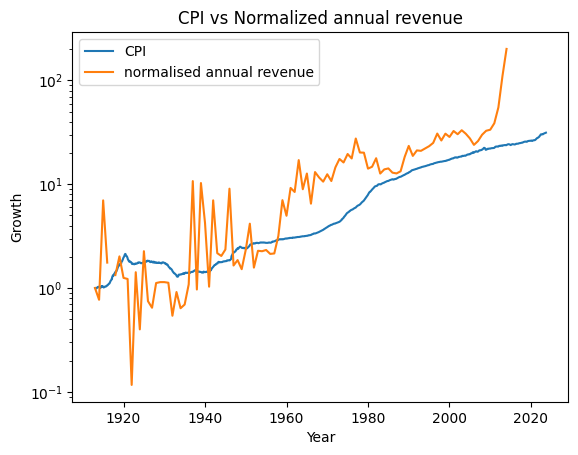

In [12]:
# Plotting normalized revenue with respect to the beginning of the data for both CPI and movie revenues

# Convert the index of mean_revenue_year to datetime format with the specified format
mean_revenue_year.index = pd.to_datetime(mean_revenue_year.index, format="%Y")

# Plot the normalized CPI values with respect to the beginning of the data using a logarithmic scale
plt.semilogy(cpi_df["value"]/(cpi_df["value"].iloc[0]),  label="CPI")

# Plot the normalized movie revenues with respect to the beginning of the data using a logarithmic scale
plt.semilogy(mean_revenue_year/mean_revenue_year.dropna().iloc[0], label="normalised annual revenue")
plt.title("CPI vs Normalized annual revenue")
plt.xlabel("Year")
plt.ylabel("Growth")
plt.legend()
plt.show()

#### Adjust the effect of inflation on the movie revenue

In [13]:
# we add an inflated revenue column, corresponding to the movie box office revenue increased to today's value according to inflation

movies["Inflated revenue"]=movies.apply(lambda x: cpi.inflate(x["Movie box office revenue"], x["Movie Year Release"]) if (not(np.isnan(x["Movie box office revenue"])))else None, axis=1)

### Financial success

We now compare a financial indicator with the increase of movie revenue through history

In [14]:
# importing S&P 500 data to compare with movie revenue
financial_indicator = yfinance.download("^GSPC", start = pd.to_datetime(movies["Movie Year Release"].min(), format="%Y"), end=pd.to_datetime(movies["Movie Year Release"].max(), format="%Y"))

[*********************100%%**********************]  1 of 1 completed


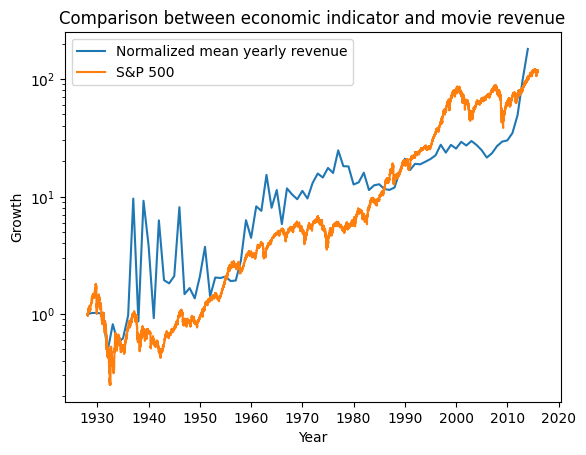

In [15]:
# we plot normalized revenue wrt the beginning of data, for both economic data and movie revenues
financial_revenue_year = mean_revenue_year[mean_revenue_year.index.year>financial_indicator.index.year.min()]
financial_revenue_year.index = pd.to_datetime(financial_revenue_year.index, format="%Y") 
plt.semilogy(financial_revenue_year/financial_revenue_year[0], label="Normalized mean yearly revenue")
plt.semilogy(financial_indicator["Close"]/financial_indicator["Close"][0], label="S&P 500")
plt.title("Comparison between economic indicator and movie revenue")
plt.xlabel("Year")
plt.ylabel("Growth")
plt.legend()
plt.show()

## Movie Duration Graph Analysis & Comparison

An analysis of the performance of a film based on its duration and its release month


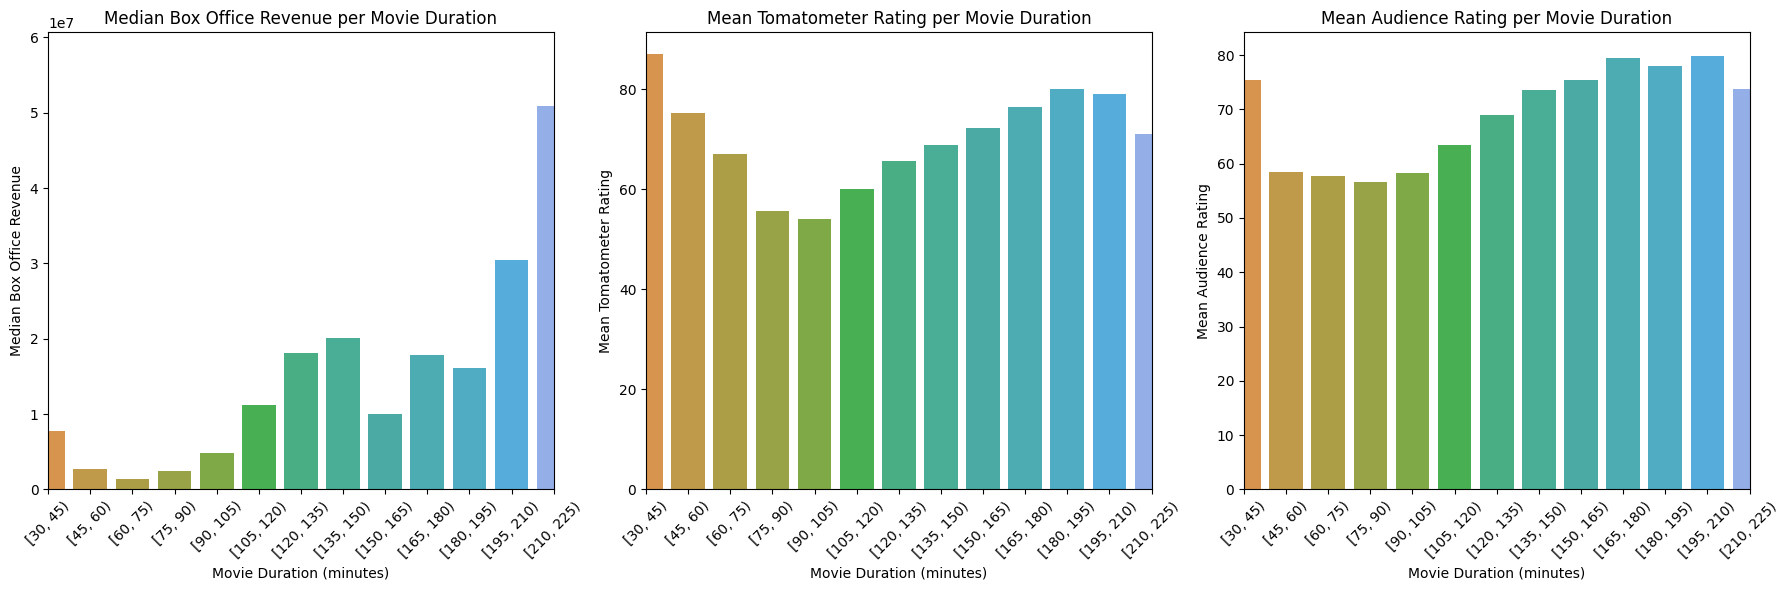

In [16]:
from helpers import convert_and_extract_date, create_length_bins, plot_movie_duration_metrics, explore_month_release_relationship
# Convert the movie release dates to datetime format and extract month and year from the datetime values
movies = convert_and_extract_date(movies)
# Create bins for movie length with a step of 15 minutes up to 300 minutes
filtered_movies, grouped_data = create_length_bins(movies)
# Compare the plots per movie duration for: median box office revenue, mean tomatometer_rating and mean audience_rating
plot_movie_duration_metrics(grouped_data)

A common trend in all 3 graphs is the strict increase of 'success' from the 75-90' movie bucket to the 165-180' movie bucket. We only considered buckets with a large enough sample size to provide more useful insight, a minimum threshold of 25 movie occurrences. Extreme values of box office revenues could heavily influence the mean, so we took the median as we have a big enough sample size and more importantly unskewed data.

### Release Month Graph Analysis & Comparison

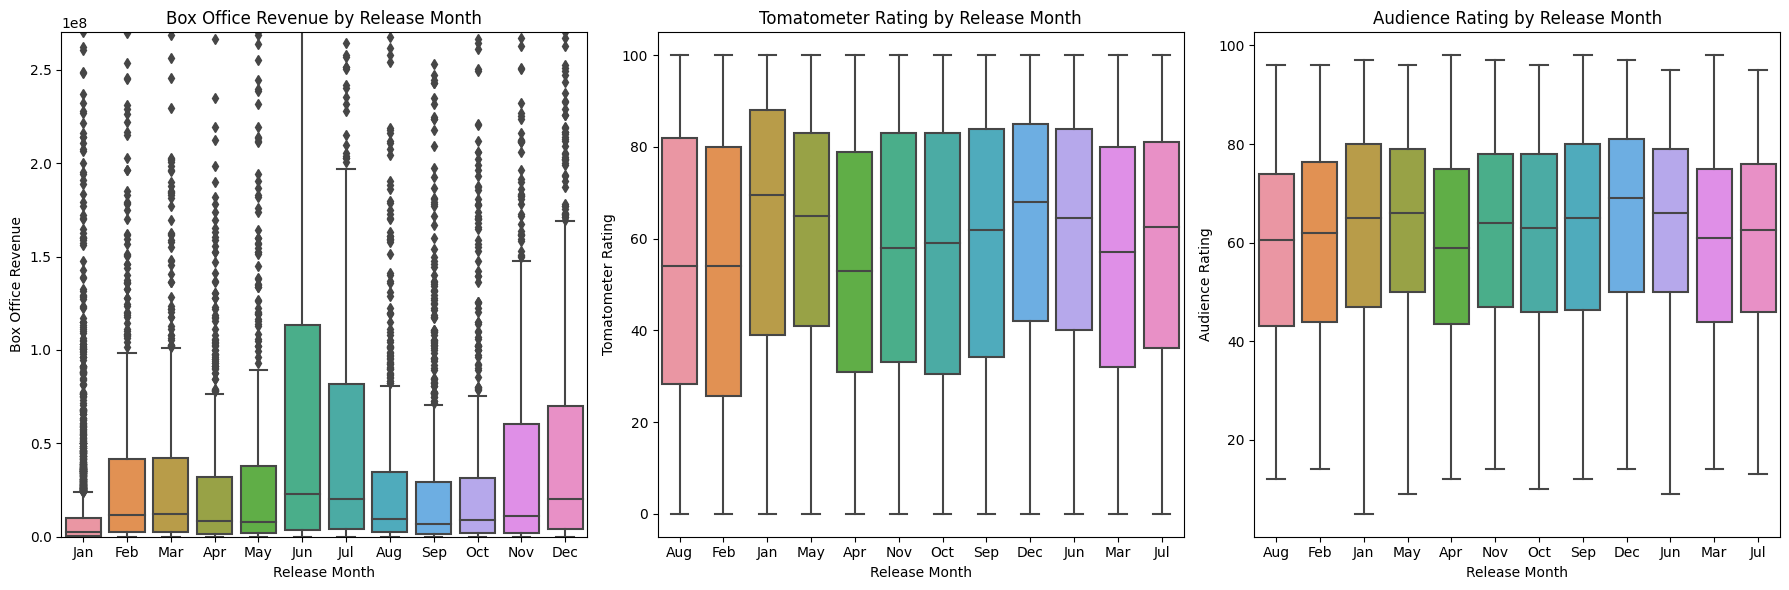

In [17]:
# View the boxplots in monthly order with literal month abbreviations
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Compare the plots per release month for: box office revenue, tomatometer_rating and audience_rating
explore_month_release_relationship(movies, month_order)

It makes sense that there is no significant relation between movie ratings and release month. The interesting plot here is the box office revenue per release month. June, July, November and December are clearly the most profitable movie release months, most likely due to the holiday seasons that can attract more viewers to cinemas. We also notice that the months that follow the holiday season are extremely unprofitable for movie releases, notably January and September: students go back to school after the summer/christmas holidays and general consumers may want to spend less money after their holiday expenses. 

## Actor Success Score (ASS)

The ASS will be score associated with the movies which will represent the quality of the team of actors. The score will be computed based on the number of actors that have been already playing in a successful. Actually, it will just be the number of such actor. An important point that will be taken into account is that for actors to be counted in the ASS, they need to have played in a successfull movie before the release date of the film on which we are computing the ASS. This score will be used afterwards in the regression with the other parameters.

### Proprecessing and data profile

Let's take the score based on the financial success to compute the ASS. Once the popularity success will be define, a similar analysis will be done.

In [18]:
# We remove the movies without value for financial success in the movies dataset.
movies_fsuccess = movies.dropna(subset='Finantial Success')

# We also consider only the characters that are played in a movie that is in the dataframe movies
characters = characters[characters['Wikipedia movie ID'].isin(movies_fsuccess['Wikipedia movie ID'])].copy()

# We can merge those two datasets to facilitate some operations. This will be usefull later on to compute the ASS.
characters_n_movies = characters.merge(movies_fsuccess, on=['Wikipedia movie ID'], how='left')

# To get a sense of the distribution of number of performances accross actors, we plot a histogram
actor = characters_n_movies.groupby('Actor name')['Actor name'].agg(['size']).sort_values("size", ascending=False)
plt.hist(actor, bins=30, log=True);
plt.grid()
plt.xlabel('Number of roles')
plt.ylabel('Number of actors')
plt.title('Actors appearance, histogram')

# How many actors are in the dataset? How many have played in more than one movie?
print("There are {} different actors in our dataset among which {} of them have played in two or more movies.".format(len(actor), len(actor[actor['size']>1])))

TypeError: Index(...) must be called with a collection of some kind, 'Finantial Success' was passed

The histogram shows us that there's a lot of actors who has played in only one movie of the dataset ~2/3. 
The actors that will influence the ASS are the one who have played in at least one movie before the release date of the interested title. Therefore, there will be around 10'000 actors that might influence the ASS which is a significant amount of data.

## Genre clustering

As we want to compare our various success metrics across genres, we need a way to cluster the movies by their assigned set of genres.
Indeed, the set of genre for each movie will partition the dataset in subsets that are too small for any statistically significant analysis.

Hence, we explore various approaches for clustering our movies along genres.
A natural approach is to use the Jaccard distance, as each of our movies have an entire set of genres instead of a single genre assigned to them.
However, K-means clustering implementations usually do not support smart centroid initialization techniques for the Jaccard distance, and coming up with one is out of the scope of this project.
Moreover, sticking with the Euclidean metric leads to much quicker execution times.

After we obtain clusters, we analyze the differences in each of our success metrics between clusters.



### One-hot encoding

The first step of our analysis consists in one-hot encoding genres to facilitate further processing, and enable a faster computation of the Jaccard distance thanks to NumPy's vectorization.

In [20]:
def one_hot_encode_genres(movies):
  # Explode the "Movie genres" column to create a new row for each genre
  movies_genres_exploded = movies['Movie genres'].explode()
  # Create new columns for each genre, each cell representing a 0-1 indicator
  # Each row is an all zeros vector with only one coordinate being set to 1
  one_hot_genres = pd.get_dummies(movies_genres_exploded) # , prefix='Genre:', prefix_sep=' ')
  # Group freshly created rows into a single one-hot vector
  one_hot_genres = one_hot_genres.groupby(one_hot_genres.index).sum().astype(bool)
  # Sort the columns to get consistent results
  one_hot_genres = one_hot_genres.reindex(sorted(one_hot_genres.columns), axis=1)
  return one_hot_genres

one_hot_genres = one_hot_encode_genres(movies)

### Most popular genres

As an initial analysis, we explore what are the most popular genres, in the sense how many movies are classified as a certain genre.

In [21]:
genre_popularity = pd.Series(one_hot_genres.sum(axis=0), name='Genre popularity')
genre_popularity.sort_values(ascending=False, inplace=True)

In [22]:
genre_popularity.head(20)

Drama               28024
Comedy              14629
Romance Film         8743
Black-and-white      8564
Thriller             7507
Action               7225
World cinema         6967
Indie                6354
Crime Fiction        5844
Short Film           5732
Horror               4380
Adventure            4233
Action/Adventure     4188
Silent film          3987
Documentary          3931
Musical              3700
Family Film          3589
Romantic drama       3197
Mystery              2703
Science Fiction      2606
Name: Genre popularity, dtype: int64

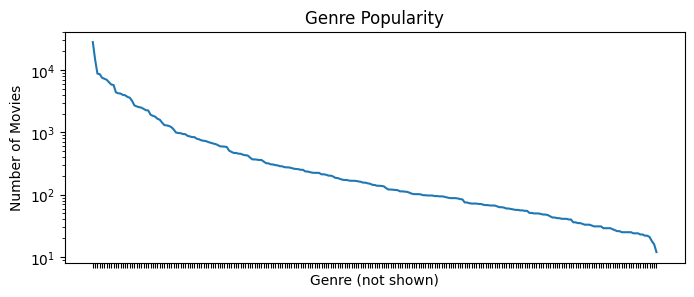

In [23]:
plt.figure(figsize=(8, 3))
plt.semilogy(genre_popularity.index, genre_popularity.values)
plt.tick_params(axis='x', labelbottom=False)
plt.yscale('log')
plt.title('Genre Popularity')
plt.xlabel('Genre (not shown)')
plt.ylabel('Number of Movies')
plt.show()

We observe that the distribution of genres follows a heavy-tailed distribution.
From this insight, we can retain only the most popular genres without loosing too many data points.
This will come in handy when we will want to cluster the genres, which is a computationally intensive task.
Hence, we take the top $N$ genres where $N$ is determined such that we don't loose more than 1% of all films.

In [24]:
def determine_number_of_retained_genres(one_hot_genres, genre_popularity, min_percentage):
    number_of_retained_genres = len(genre_popularity)
    retained_movies_percentage = 1.0

    while retained_movies_percentage > min_percentage:
        number_of_retained_genres -= 1

        # Compute the number of movies that would be lost if ignoring the next least popular genre
        popular_genres = list(genre_popularity.head(number_of_retained_genres).index)
        selected_genres = one_hot_genres[popular_genres]

        # Remove movies having no more genre assigned
        retained_movies = selected_genres[selected_genres.any(axis=1)]

        # Update new percentage
        retained_movies_percentage = len(retained_movies) / len(one_hot_genres)
    return number_of_retained_genres, retained_movies

min_percentage = 0.99
number_of_retained_genres, one_hot_genres = determine_number_of_retained_genres(one_hot_genres, genre_popularity, min_percentage)

print(f"Number of retained genres while still keeping {min_percentage*100:.2f}% of movies: {number_of_retained_genres}")
display(one_hot_genres)

Number of retained genres while still keeping 99.00% of movies: 48


,Drama,Comedy,Romance Film,Black-and-white,Thriller,Action,World cinema,Indie,Crime Fiction,Short Film,...,Sports,Family Drama,Parody,Teen,Coming of age,Martial Arts Film,Children's/Family,Television movie,History,Political drama
0,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
81737,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
81738,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
81739,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


### K-Means clustering

Here, we cluster the movies using K-means clustering with the Euclidean distance.

In [32]:
from sklearn.cluster import KMeans

We now run the $K$-means algorithm for $K = 12$.

In [34]:
k = 12
kmeans = KMeans(n_clusters=k, random_state=0xdeadbeef).fit(one_hot_genres.astype(float))

Now, we analyze the generated clusters and try to identify what kind of movies they contain by seeing the 5 most frequent genres in each cluster.
Along the way, we generate names for our clusters, by taking the most represented genres (or the next if already taken).

In [35]:
TOP_GENRES_COUNT = 5
cluster_names = []

for i, center in enumerate(kmeans.cluster_centers_):
    top_genres_indices = np.argpartition(center, -TOP_GENRES_COUNT)[-TOP_GENRES_COUNT:]
    top_genres = one_hot_genres.columns[top_genres_indices]
    sub_genre_index = 1
    while f"{top_genres[0]}/{top_genres[sub_genre_index]}" in cluster_names:
        sub_genre_index += 1
    cluster_name = f"{top_genres[0]}/{top_genres[sub_genre_index]}"
    cluster_names.append(cluster_name)
    print(f"Cluster #{i} ({cluster_name}): ", ', '.join(top_genres))

Cluster #0 (Comedy/World cinema):  Comedy, World cinema, Romantic drama, Romance Film, Drama
Cluster #1 (Drama/Musical):  Drama, Musical, Comedy, Romance Film, Romantic comedy
Cluster #2 (Indie/Crime Fiction):  Indie, Crime Fiction, World cinema, Romance Film, Drama
Cluster #3 (Crime Fiction/Drama):  Crime Fiction, Drama, Thriller, Action/Adventure, Action
Cluster #4 (Indie/Adventure):  Indie, Adventure, Black-and-white, Silent film, Drama
Cluster #5 (Crime Thriller/Thriller):  Crime Thriller, Thriller, Crime Fiction, Mystery, Drama
Cluster #6 (Science Fiction/Horror):  Science Fiction, Horror, Short Film, Comedy film, Action
Cluster #7 (World cinema/Indie):  World cinema, Indie, Comedy-drama, Comedy, Drama
Cluster #8 (Adventure/Comedy):  Adventure, Comedy, Short Film, Family Film, Animation
Cluster #9 (History/Indie):  History, Indie, Biography, Short Film, Documentary
Cluster #10 (Family Film/Parody):  Family Film, Parody, Musical, Comedy, Black-and-white
Cluster #11 (Comedy/Indie): 

Let us also check the size of each cluster:

In [36]:
from collections import Counter
counts = pd.Series(Counter(map(lambda label: cluster_names[label], kmeans.labels_)))
counts.sort_values(ascending=False, inplace=True)
display(counts)

Indie/Crime Fiction        15432
Science Fiction/Horror      9283
Family Film/Parody          6297
Crime Thriller/Thriller     5248
Indie/Adventure             4065
History/Indie               3672
Crime Fiction/Drama         3244
Comedy/World cinema         3110
Drama/Musical               2987
World cinema/Indie          2712
Comedy/Indie                2681
Adventure/Comedy            2169
dtype: int64

We now join the results from the clustering to the movies dataframe and print the assigned cluster for blockbusters, as a sanity check:

In [37]:
movies["Genre cluster"] = pd.Series([cluster_names[int(label)] for label in kmeans.labels_], index=one_hot_genres.index)
display(movies.sort_values(by="Movie box office revenue", ascending=False).head(20)[["Movie name", "Movie genres", "Genre cluster"]])

,Movie name,Movie genres,Genre cluster
23702,Avatar,"{Nature, Thriller, Adventure, Science Fiction,...",Crime Fiction/Drama
22256,Titanic,"{Period piece, Tragedy, Disaster, Drama, Roman...",Comedy/World cinema
28192,The Avengers,"{Action, Science Fiction}",Science Fiction/Horror
30278,Harry Potter and the Deathly Hallows – Part 2,"{Drama, Fantasy, Adventure, Mystery}",Indie/Crime Fiction
37601,Iron Man 3,"{Fantasy, Action, Science Fiction, Adventure}",Science Fiction/Horror
18645,Transformers: Dark of the Moon,"{Alien Film, Action, Science Fiction, Adventure}",Science Fiction/Horror
80920,The Lord of the Rings: The Return of the King,"{Film adaptation, Fantasy Adventure, Drama, Sw...",Indie/Crime Fiction
78453,Skyfall,"{Action, Thriller, Adventure}",Crime Fiction/Drama
54719,The Dark Knight Rises,"{Drama, Action, Crime Fiction, Thriller}",Crime Thriller/Thriller
2753,Pirates of the Caribbean: Dead Man's Chest,"{Fantasy Adventure, Adventure Comedy, Adventur...",Science Fiction/Horror


We observe that some films are mislabelled, however remember that our cluster names are made up, their only purpose is to be able to quickly read the data at a glance. Overall, K-means seems to produce meaningful clusters.

Finally, we observe the mean and standard deviation of our success metrics over each cluster.

In [38]:
SUCCESS_METRICS = ['audience_rating', "tomatometer_rating", "Finantial Success"]

def aggregate_per_cluster(movies, name, aggregator_function):
    aggregate = lambda group: pd.Series({
      f"{name} {success_metric}": aggregator_function(group[success_metric])
      for success_metric in SUCCESS_METRICS
    })
    return movies.groupby(by="Genre cluster").apply(aggregate)

display(aggregate_per_cluster(movies, "Avg", np.nanmean))
display(aggregate_per_cluster(movies, "Std", np.nanstd))

AttributeError: 'int' object has no attribute 'dtype'

These observations fit with our intuition.
For example, independent films (Indie/Comedy) will often be more appreciated by movie critis which are cinephile, while grossing lower due to not having the resources to advertise and pay movie theatres.
On the other hand, fiction movies (Crime Fiction and Science Fiction clusters) have higher standard deviation, which can be interpreted as them being more risky. This can be interpreted as fiction being harder to make credible.

### Genre trends

We also explore trends in genres by plotting histograms of each cluster in function of the release year.
We choose to compare the box-office inflation (adjusted for inflation).
Using this metric, we can plot the proportion of movies of a given genre, weighted by the box-office revenue for each year.

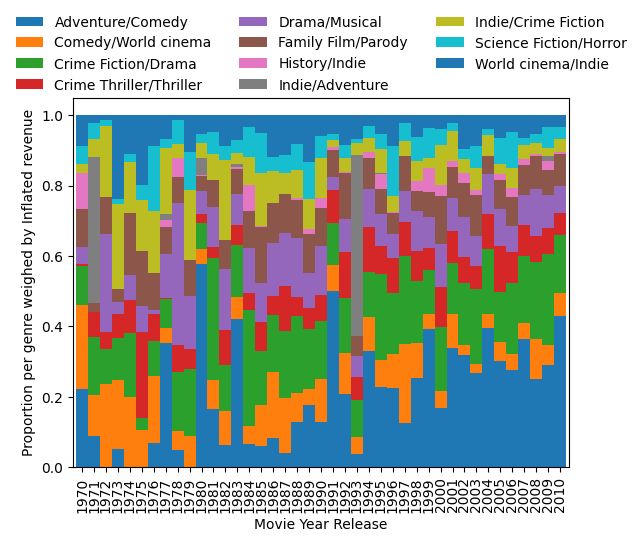

In [39]:
success_metric = 'Inflated revenue'
movie_trends = movies[["Movie Year Release", "Genre cluster", success_metric]]
movie_trends = movie_trends.dropna(subset=[success_metric])
movie_trends = movie_trends[movie_trends["Movie Year Release"].isin(range(1970, 2011))]
movie_trends = movie_trends.groupby(["Movie Year Release", "Genre cluster"])
movie_trends = movie_trends.agg(**{f"Mean {success_metric}": (success_metric, 'mean')})
movie_trends = movie_trends[f"Mean {success_metric}"].unstack(fill_value=0.0)
movie_trends = movie_trends.div(movie_trends.sum(axis=1), axis=0)

movie_trends.plot.bar(stacked=True, width=1.0)
plt.ylabel(f'Proportion per genre weighed by {success_metric}')
plt.legend(
    bbox_to_anchor=(0.5, 1.0),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)
plt.show()

We see that less war movies tend to be financially successful nowadays.
However, war movies peaked in the early 70's, which is reminiscent of the Vietnam war, which ended in 1973, afted which the success of such movies seem to decrease.
We are not sure if the success of war movies during this period is indeed causally linked to the Vietnam war and if so, whether it is the effort of U.S. government or anti-war sentiment from Hollywood directors and the general population.
Crime fictions, Science fiction and Thriller movies seem to be growing in popularity.
Consistently with our previous observation, the proportion of movies weighed by revenue of Science fiction movies seems unstable.

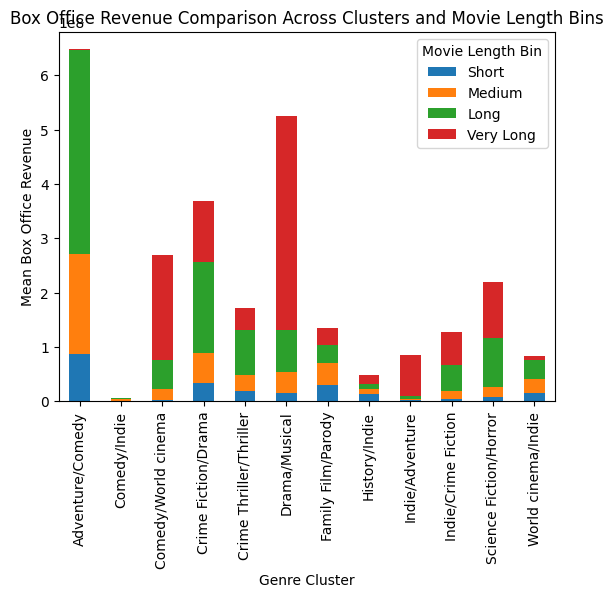

In [41]:
cluster_assignments = movies[['Movie name', 'Genre cluster']].copy()
bins = [0, 90, 120, 180, float('inf')]  # You can adjust the bin edges as needed
labels = ['Short', 'Medium', 'Long', 'Very Long']  # Label each bin
movies['Movie Length Bin'] = pd.cut(movies['Movie runtime'], bins=bins, labels=labels, right=False)
# Group by both cluster and movie length bin, then calculate mean revenue
revenue_comparison = movies.groupby(['Genre cluster', 'Movie Length Bin'])['Movie box office revenue'].mean().unstack()

# Plot the comparison
revenue_comparison.plot(kind='bar', stacked=True)
plt.title('Box Office Revenue Comparison Across Clusters and Movie Length Bins')
plt.xlabel('Genre Cluster')
plt.ylabel('Mean Box Office Revenue')
plt.legend(title='Movie Length Bin')
plt.show()

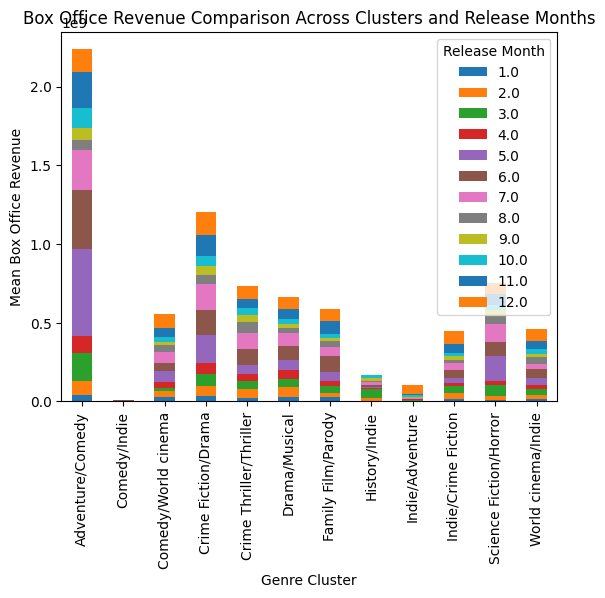

In [42]:
cluster_assignments = movies[['Movie name', 'Genre cluster']].copy()
movies['Release Month'] = pd.to_datetime(movies['original_release_date']).dt.month

# Group by both cluster and release month, then calculate mean revenue
revenue_comparison = movies.groupby(['Genre cluster', 'Release Month'])['Movie box office revenue'].mean().unstack()

# Plot the comparison
revenue_comparison.plot(kind='bar', stacked=True)
plt.title('Box Office Revenue Comparison Across Clusters and Release Months')
plt.xlabel('Genre Cluster')
plt.ylabel('Mean Box Office Revenue')
plt.legend(title='Release Month')
plt.show()